In [1]:
import os 
import json

dbname = "spanishfn"
path = os.path.join('..', 'out', '202110191402_spanishfn.json')

with open(path) as fp:
    data = json.load(fp)


In [2]:
from itertools import product

path = os.path.join('..', 'data', 'gold', f'{dbname}.txt')

with open(path, 'r') as fp:
    pairs = set(map(lambda l: tuple(l.split()), fp.readlines()))

In [3]:
en_frms = set(map(lambda x: x[0], pairs))
l2_frms = set(map(lambda x: x[1], pairs))

en_idx = [
    i
    for i, name in enumerate(data['indices'][0])
    if data['frames'][name]['name'] in en_frms
]

l2_idx = [
    i
    for i, name in enumerate(data['indices'][1])
    if data['frames'][name]['name'] in en_frms
]

In [4]:
import numpy as np

alignments = [a for a in data['alignments'] if a['type'] != 'attr_matching'] 

for alignment in alignments:
    array = np.array(alignment['data'])
    array = array[:, l2_idx]
    alignment['np_array'] = array[en_idx].flatten()

X = np.stack([a['np_array'] for a in alignments]).T

In [5]:
y = []

for f1, f2 in product(en_idx, l2_idx):
    i = data['indices'][0][f1]
    en_frm = data['frames'][i]['name']
    j = data['indices'][1][f2]
    l2_frm = data['frames'][j]['name']

    y.append(1 if (en_frm, l2_frm) in pairs else 0)
    
y = np.array(y)

In [6]:
X.shape

(881721, 11)

In [7]:
y.shape

(881721,)

In [8]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', probability=True)
svm.fit(X, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

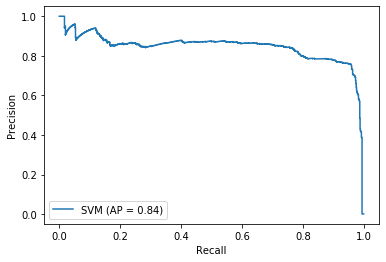

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, PrecisionRecallDisplay, precision_recall_curve

y_pred = svm.predict_proba(X).T[1]
precision, recall, _ = precision_recall_curve(y, y_pred)
average_precision = average_precision_score(y, y_pred)
disp = PrecisionRecallDisplay(precision, recall, average_precision, 'SVM')
disp.plot()
plt.show()

In [10]:
from sklearn.linear_model import LogisticRegressionCV

logreg = LogisticRegressionCV(cv=4, max_iter=1000, random_state=25)
logreg.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=4, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=25, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

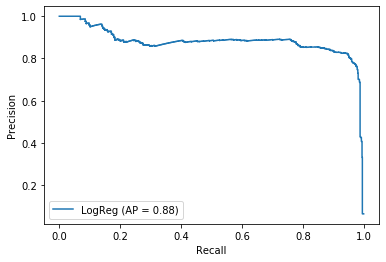

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, PrecisionRecallDisplay, precision_recall_curve

y_pred = logreg.decision_function(X)
precision, recall, _ = precision_recall_curve(y, y_pred)
average_precision = average_precision_score(y, y_pred)
disp = PrecisionRecallDisplay(precision, recall, average_precision, 'LogReg')
disp.plot()
plt.show()